In [10]:
!pip install rdkit-pypi
!pip install torch-geometric
!pip install py3Dmol

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdForceFieldHelpers import UFFHasAllMoleculeParams, UFFOptimizeMolecule
from torch_geometric.data import Data
import py3Dmol
import subprocess  # For Open Babel fallback
import logging

In [2]:
url = 'https://raw.githubusercontent.com/sussykeem/eos_predictor/refs/heads/main/preprocessed_data%20-%20preprocessed_data.csv'

In [3]:
def numpy_to_tensor(array):
  return torch.from_numpy(array).float()

def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.ndim == 2 else tensor.detach().cpu().numpy().reshape(-1, 2)

In [61]:
NOBLE_GASES = {"He", "Ne", "Ar", "Kr", "Xe", "Rn"}
NOBLE_GAS_SMILES = {f"[{g}]" for g in NOBLE_GASES} | NOBLE_GASES  # Covers [Ar] and Ar cases

class MolecularDataLoader:
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.smiles = self.data["smile"]
        self.targets = np.array(self.data[["a", "b"]])  # Real Gas Constants

        # Pre-filter noble gases
        filtered_data = []
        for s, t in zip(self.smiles, self.targets):
            if self.contains_noble_gas(s):
                print(f"❌ Skipping noble gas: {s}")
                continue  # Skip noble gases
            filtered_data.append((s, t))

        # Unzipping safely
        if filtered_data:
            self.smiles, self.targets = zip(*filtered_data)
        else:
            self.smiles, self.targets = [], []

    def contains_noble_gas(self, smiles):
        """Check if the SMILES is a noble gas molecule or contains noble gas atoms."""
        if smiles in NOBLE_GAS_SMILES:
            print(f"⚠️ Detected standalone noble gas: {smiles}")
            return True  # If SMILES itself is a noble gas

        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"⚠️ Invalid SMILES: {smiles}")
            return True  # Skip invalid SMILES

        for atom in mol.GetAtoms():
            if atom.GetSymbol() in NOBLE_GASES:
                print(f"⚠️ Detected noble gas atom in: {smiles}")
                return True  # If any atom is a noble gas

        return False


    def optimize_molecule(self, mol, smiles):
      """ Try MMFF94 first, then UFF, then Open Babel as a last resort. """
      try:
          if AllChem.MMFFHasAllMoleculeParams(mol):
              AllChem.MMFFOptimizeMolecule(mol)
              return mol
          elif AllChem.UFFHasAllMoleculeParams(mol):
              print(f"⚠️ MMFF94 not available for {smiles}, using UFF instead...")
              AllChem.UFFOptimizeMolecule(mol)
              return mol
          else:
              print(f"⚠️ UFF failed for {smiles}, skipping molecule...")
              return None  # Skip molecule instead of trying Open Babel
      except Exception as e:
          print(f"❌ Optimization failed for {smiles}: {e}")
          return None  # Skip molecule


    def optimize_with_openbabel(self, smiles):
        """ Fallback optimization using Open Babel CLI. """
        try:
            result = subprocess.run(
                ["obabel", "-:", smiles, "--gen3D", "--ff", "uff", "-O", "output.mol"],
                capture_output=True, text=True
            )
            if result.returncode == 0:
                return Chem.MolFromMolFile("output.mol")
            else:
                print(f"❌ Open Babel failed for {smiles}: {result.stderr}")
                return None
        except Exception as e:
            print(f"❌ Open Babel not available: {e}")
            return None

    def smiles_to_graph(self, smiles):
      mol = Chem.MolFromSmiles(smiles)
      if mol is None:
          print(f"❌ Invalid SMILES string: {smiles}")
          return None

      mol = Chem.AddHs(mol)

      # Try embedding
      mol = embed_molecule(mol)
      if mol is None:
          return None  # Skip molecule if embedding fails

      # Optimization
      mol = self.optimize_molecule(mol, smiles)
      if mol is None:
          return None  # Skip molecule if optimization fails

      # Nodes (Atoms)
      atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
      x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)

      # Edges (Bonds)
      edge_index = []
      for bond in mol.GetBonds():
          i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
          edge_index.append((i, j))
          edge_index.append((j, i))
      edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

      # Positions (3D Coordinates)
      try:
          conf = mol.GetConformer()
          pos = torch.tensor(
              [list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())],
              dtype=torch.float
          )
      except:
          print(f"❌ Failed to get conformer for {smiles}")
          return None  # Skip molecule if conformer is missing

      return Data(x=x, edge_index=edge_index, pos=pos)

def embed_molecule(mol):
    """Attempt to embed a molecule using ETKDGv3, fallback to random coords."""
    params = AllChem.ETKDGv3()
    params.useSmallRingTorsions = True
    params.useRandomCoords = True  # Enables random embedding fallback

    result = AllChem.EmbedMolecule(mol, params)
    if result != 0:
        print(f"⚠️ ETKDGv3 failed for {Chem.MolToSmiles(mol)}. Trying random embedding...")
        result = AllChem.EmbedMolecule(mol, useRandomCoords=True)

    if result != 0:
        print(f"❌ ETKDG and random embedding failed. Skipping molecule.")
        return None  # Skip molecule if embedding fails
    return mol

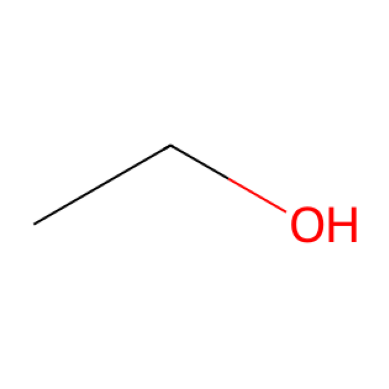

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [19]:
class MoleculeVisualizer():
    def visualize_molecule_3D(self,smiles):
      """
      Generates and visualizes the 3D molecular structure from a SMILES string.
      Uses RDKit to compute 3D coordinates and py3Dmol for interactive rendering.
      """
      mol = Chem.MolFromSmiles(smiles)

      if mol is None:
          print("Invalid SMILES string.")
          return

      # Add hydrogens and compute 3D coordinates
      mol = Chem.AddHs(mol)
      AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # Generate 3D structure
      AllChem.UFFOptimizeMolecule(mol)  # Optimize structure

      # Convert molecule to MOL block format (3D coordinates)
      mol_block = Chem.MolToMolBlock(mol)

      # 3D Visualization using py3Dmol
      viewer = py3Dmol.view(width=400, height=400)
      viewer.addModel(mol_block, "mol")  # Load 3D molecule
      viewer.setStyle({"stick": {}})  # Stick representation
      viewer.zoomTo()  # Auto-zoom
      return viewer.show()

    def visualize_molecule_2D(self,smiles):
        """
        Generates a 2D image of the molecule from its SMILES representation.
        """
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print("Invalid SMILES string.")
            return

        img = Draw.MolToImage(mol, size=(300, 300))
        plt.imshow(img)
        plt.axis("off")
        plt.show()

    # Example Usage:
    # visualize_molecule_2D("CCO")  # Ethanol

v = MoleculeVisualizer()
v.visualize_molecule_2D("CCO")
v.visualize_molecule_3D("CCO")

In [57]:
class MolecularGraphDataset(Dataset):
    def __init__(self, dataloader):
        super().__init__()
        self.graphs = []
        self.targets = []

        for smile, target in zip(dataloader.smiles, dataloader.targets):
            graph = dataloader.smiles_to_graph(smile)
            if graph is not None:
                self.graphs.append(graph)
                self.targets.append(torch.tensor(target, dtype=torch.float))
            else:
                logging.warning(f"Skipping invalid molecule: {smile}")

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, index):
        return self.graphs[index], self.targets[index]

In [65]:
class MolecularGNN(torch.nn.Module):
    def __init__(self, node_dim=1, hidden_dim=64, output_dim=2, lr=0.001):
        super().__init__()
        self.conv1 = GCNConv(node_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

        # Training parameters
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss_fn = torch.nn.MSELoss()
        self.to(self.device)

    def forward(self, data):
        x, edge_index, pos = data.x, data.edge_index, data.pos
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, data.batch)
        return self.fc(x)

    def train_model(self, train_loader, epochs=10):
        self.train()
        for epoch in range(epochs):
            total_loss = 0
            for data, target in train_loader:
                if data is None or data.edge_index.numel() == 0:
                    print("Skipping empty molecule graph")
                    continue
                data, target = data.to(self.device), target.to(self.device)

                self.optimizer.zero_grad()
                output = self(data)
                loss = self.loss_fn(output, target)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

    def evaluate_model(self, test_loader):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self(data)
                loss = self.loss_fn(output, target)
                total_loss += loss.item()

        avg_loss = total_loss / len(test_loader)
        print(f"Test Loss: {avg_loss:.4f}")
        return avg_loss

    def predict(self, smiles, dataloader):
        self.eval()
        graph = dataloader.smiles_to_graph(smiles)
        if graph is None:
            return None

        graph = graph.to(self.device)
        with torch.no_grad():
            prediction = self(graph)

        return prediction.cpu().numpy()

In [66]:
loader = MolecularDataLoader(url)
dataset = MolecularGraphDataset(loader)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Model Instance
model = MolecularGNN()
model.train_model(train_loader, epochs=1000)

# Evaluate
test_loader = DataLoader(dataset, batch_size=16, shuffle=False)
model.evaluate_model(test_loader)

[18:52:42] WARNING: not removing hydrogen atom without neighbors
[18:52:42] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[18:52:42] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[18:52:42] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[18:52:42] WARNING: not removing hydrogen atom without neighbors
[18:52:42] UFFTYPER: Warning: hybridization set to SP for atom 0
[18:52:42] UFFTYPER: Unrecognized charge state for atom: 0
[18:52:42] UFFTYPER: Warning: hybridization set to SP for atom 0
[18:52:42] UFFTYPER: Unrecognized charge state for atom: 0
[18:52:42] UFFTYPER: Warning: hybridization set to SP for atom 0
[18:52:42] UFFTYPER: Unrecognized charge state for atom: 0
[18:52:43] UFFTYPER: Unrecognized charge state for atom: 0
[18:52:43] UFFTYPER: Unrecognized charge state for atom: 0
[18:52:43] UFFTYPER: Unrecognized charge state for atom: 0
[18:52:43] UFFTYPER: Unrecognized charge state for atom: 0
[18:52:43] UFFTYPER: Unrecognized charge state for atom: 0
[18:5

⚠️ Detected standalone noble gas: [Ar]
❌ Skipping noble gas: [Ar]
⚠️ Detected standalone noble gas: [He]
❌ Skipping noble gas: [He]
⚠️ Detected standalone noble gas: [Kr]
❌ Skipping noble gas: [Kr]
⚠️ Detected standalone noble gas: [Ne]
❌ Skipping noble gas: [Ne]
⚠️ Detected standalone noble gas: [Rn]
❌ Skipping noble gas: [Rn]
⚠️ Detected standalone noble gas: [Xe]
❌ Skipping noble gas: [Xe]
⚠️ Detected noble gas atom in: F[Xe]F
❌ Skipping noble gas: F[Xe]F
⚠️ Detected noble gas atom in: F[Xe](F)(F)F
❌ Skipping noble gas: F[Xe](F)(F)F
⚠️ MMFF94 not available for [Al](Cl)(Cl)Cl, using UFF instead...
⚠️ MMFF94 not available for B(Cl)(Cl)Cl, using UFF instead...
⚠️ MMFF94 not available for B(F)(F)F, using UFF instead...
⚠️ MMFF94 not available for B.B, using UFF instead...
⚠️ MMFF94 not available for Cl[Ge](Cl)(Cl)Cl, using UFF instead...
⚠️ MMFF94 not available for [GeH4], using UFF instead...
⚠️ MMFF94 not available for Br, using UFF instead...
⚠️ MMFF94 not available for Cl, using UFF

251.74306978498186